In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import datetime
from plotly.offline import iplot
import yfinance as yf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
need_row_data = False
load_data = True

seed = 42

period = '6y'
interval = '1d'

N = 10 

train_size = 0.9          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.9

# Load data

In [3]:
if need_row_data:
    csvs = [
        '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'
    ]

    tickers = pd.DataFrame()
    for csv in csvs:
        data = pd.read_csv(f'data/row_jap/{csv}.csv')
        tickers = pd.concat([tickers, data], axis=0)

    with open('models/row_jap_stock.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tickers = tickers[['ｺｰﾄﾞ', '会社名', '業種', '時価総額\r\n(10億円)']]
    tickers.rename(columns={"ｺｰﾄﾞ": "ticker", "会社名": "company", "業種":"sector", "時価総額\r\n(10億円)": "market_cap"}, inplace=True)
    tickers.replace(',','', regex=True, inplace=True)
    tickers['market_cap'] = tickers['market_cap'].astype(str).astype(int)

    with open('data/jap_ticker.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/jap_ticker.pickle', 'rb') as handle:
        tickers = pickle.load(handle)

tickers.head()

,ticker,company,sector,market_cap
0,7203,トヨタ自動車,自動車・自動車部品,33576
1,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上,その他金融,15764
2,9432,日本電信電話,通信,13858
3,6758,ソニーグループ,電気機器,13658
4,6861,キーエンス,電気機器,11667


In [4]:
if load_data:
    dfs = []

    forex_data = yf.download('USDJPY=X', period=period, interval=interval, progress=False)
    forex_data.rename({"Adj Close": 'forex'}, inplace=True, axis=1)
    forex = forex_data[['forex']]

    dji_data = yf.download('^dji', period=period, interval=interval, progress=False)
    dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
    dji = dji_data[['dji']]#.shift(1)

    for i, company in tqdm_notebook(tickers.iterrows(), total=len(tickers)):
        ticker = str(company["ticker"]) + '.T'
        try:
            temp_df = yf.download(ticker, period=period, interval=interval, progress=False)
            # create ticker column and sector column
            temp_df = pd.concat([temp_df, forex, dji], axis=1, join='inner')
            temp_df['ticker'] = ticker
            temp_df['sector'] = company["sector"]

            dfs.append(temp_df)
        except Exception as e: print(e)

else:
    with open('temp/jp_company_data_2022_07_13.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].tail()

  0%|          | 0/300 [00:00<?, ?it/s]

,Open,High,Low,Close,Adj Close,Volume,forex,dji,ticker,sector
Date,,,,,,,,,,
2022-07-11,2140.0,2158.5,2134.0,2152.0,2152.0,28062000,136.300995,31173.839844,7203.T,自動車・自動車部品
2022-07-12,2152.0,2153.0,2110.5,2116.5,2116.5,24129000,137.388000,30981.330078,7203.T,自動車・自動車部品
2022-07-13,2124.0,2145.5,2123.5,2134.5,2134.5,16445800,136.725998,30772.789062,7203.T,自動車・自動車部品
2022-07-14,2101.5,2144.0,2098.5,2135.0,2135.0,18559500,137.628006,30630.169922,7203.T,自動車・自動車部品
2022-07-15,2133.5,2163.5,2127.0,2163.0,2163.0,28589600,138.533997,31288.259766,7203.T,自動車・自動車部品


In [5]:
#with open('temp/jp_company_data_2022_07_14.pickle', 'wb') as handle:
#    pickle.dump(dfs, handle)

In [6]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-1) / temp_df['adj_close'])-1)
    temp_df['dji_ret'] = 100.0 * ((temp_df['dji'].shift(1) / temp_df['dji'])-1)*-1
    temp_df['forex_ret'] = 100.0 * ((temp_df['dji'].shift(1) / temp_df['dji'])-1)*-1

    # create weekday column
    date = pd.to_datetime(temp_df['date']).dt
    temp_df['weekday'] = date.weekday
    temp_df['month'] = date.month
    temp_df['year'] = date.year

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].tail()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,dji_ret,forex_ret,weekday,month,year
1426,2022-07-11,2140.0,2158.5,2134.0,2152.0,2152.0,28062000,136.300995,31173.839844,7203.T,自動車・自動車部品,-1.649628,-0.527078,-0.527078,0,7,2022
1427,2022-07-12,2152.0,2153.0,2110.5,2116.5,2116.5,24129000,137.388000,30981.330078,7203.T,自動車・自動車部品,0.850461,-0.621373,-0.621373,1,7,2022
1428,2022-07-13,2124.0,2145.5,2123.5,2134.5,2134.5,16445800,136.725998,30772.789062,7203.T,自動車・自動車部品,0.023425,-0.677680,-0.677680,2,7,2022
1429,2022-07-14,2101.5,2144.0,2098.5,2135.0,2135.0,18559500,137.628006,30630.169922,7203.T,自動車・自動車部品,1.311475,-0.465617,-0.465617,3,7,2022
1430,2022-07-15,2133.5,2163.5,2127.0,2163.0,2163.0,28589600,138.533997,31288.259766,7203.T,自動車・自動車部品,NaN,2.103312,2.103312,4,7,2022


# Feature Engineering

## Simple Moving Average

In [7]:
# Simple moving average
for temp_df in dfs:
    temp_df['sma_10'] = temp_df['adj_close'].rolling(window = 10).mean()
    temp_df['sma_20'] = temp_df['adj_close'].rolling(window = 20).mean()
    temp_df['sma_50'] = temp_df['adj_close'].rolling(window = 50).mean()
    temp_df['sma_100'] = temp_df['adj_close'].rolling(window = 100).mean()
    temp_df['sma_200'] = temp_df['adj_close'].rolling(window = 200).mean()

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200'].shift(1)

    # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > temp_df['sma_20']).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > temp_df['sma_50']).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > temp_df['sma_100']).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > temp_df['sma_200']).astype(int)

    temp_df['sma_10above20'] = (temp_df['sma_10'] > temp_df['sma_20']).astype(int)
    temp_df['sma_10above50'] = (temp_df['sma_10'] > temp_df['sma_50']).astype(int)
    temp_df['sma_10above100'] = (temp_df['sma_10'] > temp_df['sma_100']).astype(int)
    temp_df['sma_10above200'] = (temp_df['sma_10'] > temp_df['sma_200']).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < temp_df['sma_200'])).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['sma_10'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['sma_10'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['sma_10'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['sma_10'] < temp_df['sma_200'])).astype(int)

    dfs[0].head()

In [8]:
# Del unneccesary cols
for df in dfs:
    df.drop(['sma_10', 'sma_50', 'sma_100', 'sma_200',
             'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [9]:
for df in dfs:
    # Exponential moving average
    df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
    df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
    df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
    df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
    df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

    # Get the ema on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['ema_10_lag_1'] = df['ema_10'].shift(1)
    df['ema_20_lag_1'] = df['ema_20'].shift(1)
    df['ema_50_lag_1'] = df['ema_50'].shift(1)
    df['ema_100_lag_1'] = df['ema_100'].shift(1)
    df['ema_200_lag_1'] = df['ema_200'].shift(1)

    # Get above signals
    df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
    df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
    df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
    df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

    df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
    df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
    df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
    df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092041,50186500,106.146004,18559.009766,7203.T,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696106,38045500,106.137001,18595.029297,7203.T,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-21,1170.000000,1176.800049,1164.599976,1175.000000,911.205933,53035000,107.204002,18517.230469,7203.T,...,1,1,0,0,0,0,0,0,0,0
3,2016-07-22,1154.000000,1173.199951,1154.000000,1167.599976,905.467285,40033500,105.810997,18570.849609,7203.T,...,0,0,0,0,0,0,0,0,0,0
4,2016-07-25,1167.599976,1179.800049,1164.199951,1169.199951,906.708069,39006000,106.325996,18493.060547,7203.T,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
             'ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [11]:
for df in dfs:
    # Exponential moving average
    df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Get the macd on the previous day
    df['macd_lag_1'] = df['macd'].shift(1)
    df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,ema_10cut100down,ema_10cut200down,ema_12,ema_26,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092041,50186500,106.146004,18559.009766,7203.T,...,0,0,897.092041,897.092041,0.000000,0.000000,NaN,NaN,0,0
1,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696106,38045500,106.137001,18595.029297,7203.T,...,0,0,896.877282,896.988638,-0.111357,-0.022271,0.000000,0.000000,0,0
2,2016-07-21,1170.000000,1176.800049,1164.599976,1175.000000,911.205933,53035000,107.204002,18517.230469,7203.T,...,0,0,899.081690,898.041771,1.039918,0.190167,-0.111357,-0.022271,1,0
3,2016-07-22,1154.000000,1173.199951,1154.000000,1167.599976,905.467285,40033500,105.810997,18570.849609,7203.T,...,0,0,900.064089,898.591809,1.472280,0.446589,1.039918,0.190167,0,0
4,2016-07-25,1167.599976,1179.800049,1164.199951,1169.199951,906.708069,39006000,106.325996,18493.060547,7203.T,...,0,0,901.086240,899.193014,1.893226,0.735917,1.472280,0.446589,0,0


In [12]:
for df in dfs:
    # Del unneccesary cols
    df.drop(['ema_12', 'ema_26', 'macd_signal', 'macd_lag_1', 'macd_signal_lag_1'], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [13]:
for df in dfs:
    # Generate fast and slow stochastic oscillators
    df['lowest_14'] = df['close'].rolling(window = 14).min()
    df['highest_14'] = df['close'].rolling(window = 14).max()
    df['stochastic_fast'] = 100.0*(df['close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
    df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,lowest_14,highest_14,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092041,50186500,106.146004,18559.009766,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696106,38045500,106.137001,18595.029297,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-21,1170.000000,1176.800049,1164.599976,1175.000000,911.205933,53035000,107.204002,18517.230469,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-07-22,1154.000000,1173.199951,1154.000000,1167.599976,905.467285,40033500,105.810997,18570.849609,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-07-25,1167.599976,1179.800049,1164.199951,1169.199951,906.708069,39006000,106.325996,18493.060547,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [14]:
# Del unneccesary cols
for df in dfs:
    df.drop(['lowest_14', 
             'highest_14', 
             'stochastic_fast_lag_1', 
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [15]:
for df in tqdm_notebook(dfs):
    # Get gain and loss columns
    df['gain'] = df['daily_ret']
    df.loc[df['gain']<0, 'gain'] = 0

    df['loss'] = df['daily_ret']
    df.loc[df['loss']>0, 'loss'] = 0
    df['loss'] = abs(df['loss'])

    # Get avg_gain, avg_loss columns
    df['avg_gain'] = df['gain'].rolling(window = 14, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window = 14, min_periods=1).mean()

    for index, row in df[15:].iterrows():
        df.loc[index, 'avg_gain'] = (df.loc[index-1, 'avg_gain']*13 + row['gain'])/14
        df.loc[index, 'avg_loss'] = (df.loc[index-1, 'avg_loss']*13 + row['loss'])/14

    # Calc RSI
    df['rsi'] = 100 - 100/(1+(df['avg_gain']/df['avg_loss']))
    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0][20:25]

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,gain,loss,avg_gain,avg_loss,rsi,rsi_ob,rsi_os
20,2016-08-17,1179.599976,1206.599976,1176.400024,1201.199951,931.523987,46661500,100.199997,18573.939453,7203.T,...,0,0,1,0.000000,1.764916,0.816931,0.730183,52.803520,0,0
21,2016-08-18,1187.000000,1196.400024,1180.000000,1180.000000,915.083374,50021000,99.905998,18597.699219,7203.T,...,1,0,0,2.135596,0.000000,0.911121,0.678027,57.333916,0,0
22,2016-08-19,1193.800049,1212.000000,1191.199951,1205.199951,934.625854,59721500,100.112000,18552.570312,7203.T,...,0,0,1,1.227997,0.000000,0.933755,0.629597,59.727756,0,0
23,2016-08-22,1215.599976,1221.800049,1213.000000,1220.000000,946.103027,45650500,100.554001,18529.419922,7203.T,...,0,0,1,0.000000,1.688490,0.867058,0.705232,55.146191,0,0
24,2016-08-23,1212.599976,1216.000000,1197.000000,1199.400024,930.128174,42580500,100.250999,18547.300781,7203.T,...,1,0,0,2.051017,0.000000,0.951627,0.654858,59.236573,0,0


In [16]:
dfs[0]['gain'].shape

(1431,)

In [17]:
# Del unneccesary cols
for df in dfs:
    df.drop(['gain', 
             'loss'
            ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [18]:
for df in tqdm_notebook(dfs):
    # Get atr
    df['close_lag_1'] = df['close'].shift(1)
    df['tr'] = np.maximum(df['high']-df['low'], np.maximum(abs(df['high']-df['close_lag_1']), abs(df['low']-df['close_lag_1'])))
    df['atr'] = df['tr'].rolling(window = 14).mean()
    
    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    df['atr_signal'] = (df['high'] > ((df['close_lag_1'] + df['atr']))).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < ((df['close_lag_1'] - df['atr']))).astype(int)

  0%|          | 0/300 [00:00<?, ?it/s]

In [19]:
# Del unneccesary cols
for df in dfs:
    df.drop(['close_lag_1'], axis=1, inplace=True)  

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [20]:
def comp_pdm(high, high_lag_1, low, low_lag_1):
    if (high-high_lag_1) > (low_lag_1-low):
        return(max(high-high_lag_1, 0))
    else:
        return 0

def comp_mdm(high, high_lag_1, low, low_lag_1):
    if (low_lag_1-low) > (high-high_lag_1):
        return(max(low_lag_1-low, 0))
    else:
        return 0

for i, df in tqdm_notebook(enumerate(dfs), total=len(dfs)):

    # Get +/- directional movement
    df['high_lag_1'] = df['high'].shift(1)
    df['low_lag_1'] = df['low'].shift(1)

    df['+dm'] = df.apply(lambda row: comp_pdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
    df['-dm'] = df.apply(lambda row: comp_mdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)

    # Get smoothed +/- directional movement
    df['smoothed+dm'] = 0
    df.loc[14, 'smoothed+dm'] = df[1:15]['+dm'].sum()
    
    df['smoothed-dm'] = 0
    df.loc[14, 'smoothed-dm'] = df[1:15]['-dm'].sum()
    
    df['14tr'] = 0
    df.loc[14, '14tr'] = df[1:15]['tr'].sum()

    for index, row in df[15:].iterrows():
        df.loc[index, 'smoothed+dm'] = df.loc[index-1, 'smoothed+dm'] - (df.loc[index-1, 'smoothed+dm']/14) + row['+dm']
        df.loc[index, 'smoothed-dm'] = df.loc[index-1, 'smoothed-dm'] - (df.loc[index-1, 'smoothed-dm']/14) + row['-dm']
        df.loc[index, '14tr'] = df.loc[index-1, '14tr'] - (df.loc[index-1, '14tr']/14) + row['tr']
        
    # Get +/- directional index
    df['+di'] = 100.0*(df['smoothed+dm']/df['14tr'])
    df['-di'] = 100.0*(df['smoothed-dm']/df['14tr'])
    
    # Get directional movement index
    df['dx'] = 100.0 * (abs(df['+di']-df['-di'])/abs(df['+di']+df['-di']))
    
    # Get average directional movement index
    df.loc[27, 'adx'] = df[14:28]['dx'].mean()
    for index, row in df[28:].iterrows():
        df.loc[index, 'adx'] = (df.loc[index-1, 'adx']*13 + row['dx'])/14

    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)
    
    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


  0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
# Del unneccesary cols
for df in dfs:
    df.drop(['+di',
             '-di',
             '+di_lag_1',
             '-di_lag_1',
             'tr', 
             '+dm', 
             '-dm', 
             'smoothed+dm',
             'smoothed-dm',
             '14tr',
             'dx',
             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [22]:
for df in dfs:
    df['std_20'] = df['adj_close'].rolling(window = 20).std()
    df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
    df['bollinger_low'] = df['sma_20'] - 2*df['std_20']
    
    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
    df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']
    
    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
    df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)


In [23]:
# Del unneccesary cols
for df in dfs:
    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [24]:
# Check if all signals true on any day
df = dfs[0]
df[(df['macd_crossover']==1) & 
   (df['stochastic_fastcutslow']==1) &
   (df['atr_signal']==1) & 
   (df['adx_bull']==1)]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,low_lag_1,adx,adx_strength,adx_trendless,adx_bull,adx_bear,bollinger_upp_dist,bollinger_low_dist,bollinger_ob,bollinger_os


In [25]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'sma_20',
             'adj_close_lag_1',
             'high_lag_1',
             'low_lag_1',
             'dji'
             ], axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1431 entries, 0 to 1430
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1431 non-null   datetime64[ns]
 1   adj_close                   1431 non-null   float64       
 2   forex                       1431 non-null   float64       
 3   ticker                      1431 non-null   object        
 4   sector                      1431 non-null   object        
 5   daily_ret                   1430 non-null   float64       
 6   dji_ret                     1430 non-null   float64       
 7   forex_ret                   1430 non-null   float64       
 8   weekday                     1431 non-null   int64         
 9   month                       1431 non-null   int64         
 10  year                        1431 non-null   int64         
 11  sma_above20                 1431 non-null   int64       

# EDA

In [27]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in tqdm_notebook(dfs):
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [28]:
# create lag for daily return to N days ahead
dfs_lags = add_lags(dfs, ['daily_ret'], N)
dfs_lags = add_lags(dfs, ['dji_ret'], 5)
dfs_lags = add_lags(dfs, ['forex_ret'], 3)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

(1431, 87)

In [29]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(['date', 'daily_ret', 'sector', 'ticker', 'weekday', 'month', 'year', 'dji_ret', 'forex', 'forex_ret']))
tech_indicators.sort()

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1431, 162)

In [30]:
#for df in dfs_lags:
#    df.drop([f'{tech_indicator}_lag_1' for tech_indicator in tech_indicators], axis=1, inplace=True)

In [31]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
    df.drop(['forex', 'year'], axis=1, inplace=True)
dfs_lags[0].shape

(1431, 85)

# Encode Label

In [32]:
#with open('temp/v7_predict.pickle', 'wb') as handle:
#    pickle.dump(dfs_lags, handle)

In [33]:
df_lags = pd.concat(dfs_lags)

In [34]:
df_lags.shape

(426949, 85)

In [35]:
df_lags = df_lags[(abs(df_lags['daily_ret']) <= 50) | (df_lags['daily_ret'].isna())]

In [36]:
with open('v7/enc_date.pickle', 'rb') as handle:
    date_encoder = pickle.load(handle)

with open('v7/enc_sector.pickle', 'rb') as handle:
    sector_encoder = pickle.load(handle)

with open('v7/enc_ticker.pickle', 'rb') as handle:
    ticker_encoder = pickle.load(handle)

In [37]:

a = np.array([pd.Timestamp(date) for date in date_encoder.classes_])
date_encoder_dict = dict(zip(a, date_encoder.transform(date_encoder.classes_)))

last_date = list(date_encoder_dict.keys())[-1]
last_date_encoder = list(date_encoder_dict.values())[-1]
for i in range(1, 365):
    new_date = last_date + np.timedelta64(i, 'D')
    last_date_encoder += 1
    date_encoder_dict[new_date] = last_date_encoder

In [38]:
# label encode for categorical variables: sector and ticker column
df_lags['date'] = df_lags['date'].apply(
    lambda x: date_encoder_dict.get(x)
)
df_lags['sector'] = sector_encoder.transform(df_lags['sector'])

df_lags['ticker'] = ticker_encoder.transform(df_lags['ticker'])
df_lags.head()

,date,ticker,sector,daily_ret,dji_ret,forex_ret,weekday,month,forex_ret_lag_1,forex_ret_lag_2,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
0,6,186,21,-0.155607,NaN,NaN,1,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,186,21,1.731595,0.193705,0.193705,2,7,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,8,186,21,-0.629786,-0.420143,-0.420143,3,7,0.193705,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,9,186,21,0.137032,0.288727,0.288727,4,7,-0.420143,0.193705,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,10,186,21,-2.514536,-0.420639,-0.420639,0,7,0.288727,-0.420143,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [39]:
df_lags[df_lags['date'] == (df_lags['date'].max())].tail()

,date,ticker,sector,daily_ret,dji_ret,forex_ret,weekday,month,forex_ret_lag_1,forex_ret_lag_2,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1430,1438,231,27,NaN,2.103312,2.103312,4,7,-0.465617,-0.67768,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,23.095238
1430,1438,85,9,NaN,2.103312,2.103312,4,7,-0.465617,-0.67768,...,0.0,0.0,0.0,0.0,94.594595,1.0,0.0,1.0,0.0,79.502546
1430,1438,283,29,NaN,2.103312,2.103312,4,7,-0.465617,-0.67768,...,0.0,0.0,0.0,0.0,81.355932,0.0,1.0,1.0,0.0,93.060673
1430,1438,284,29,NaN,2.103312,2.103312,4,7,-0.465617,-0.67768,...,0.0,0.0,0.0,0.0,94.285714,0.0,1.0,1.0,0.0,98.095238
1430,1438,70,9,NaN,2.103312,2.103312,4,7,-0.465617,-0.67768,...,0.0,0.0,0.0,0.0,1.510574,1.0,0.0,0.0,1.0,0.503525


# Predicting data

In [40]:
non_na = list(df_lags.columns)
non_na.remove('daily_ret')
df_lags.dropna(subset=non_na, inplace=True)

In [41]:
pd.set_option('display.max_columns', 500)

In [42]:
temp = df_lags.copy(deep=True)

In [43]:
df_lags = temp.copy(deep=True)

In [543]:
days_ago = 9
get_models = False

In [544]:
predicting = df_lags[df_lags['date'] == (df_lags['date'].max() - days_ago)]#df_lags.sort_values(by='date')[-20000:]
predicting.drop(columns=['date'], inplace=True)
actual = predicting['daily_ret']
predicting.drop(['daily_ret'], axis=1, inplace=True)

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_46648/3758097173.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_46648/3758097173.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [545]:
predicting.head()

,ticker,sector,dji_ret,forex_ret,weekday,month,forex_ret_lag_1,forex_ret_lag_2,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1423,186,21,0.225079,0.225079,2,7,-0.417981,1.034915,2116.5,8.945153,0.0,0.0,0.0,1.0,54.642857,1.0,0.0,0.755504,0.964875,77.086576,0.0,0.0,120.936576,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.809153,0.0,0.0,43.914983,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,51.196172,1.0,0.0,0.0,0.0,27.119481
1422,1,2,0.225079,0.225079,2,7,-0.417981,1.034915,1983.5,13.798424,0.0,0.0,0.0,1.0,31.357143,1.0,0.0,0.459057,0.549592,78.155467,0.0,0.0,97.455467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.353257,0.0,0.0,45.512067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.562914,1.0,0.0,0.0,0.0,39.319971
1423,275,23,0.225079,0.225079,2,7,-0.417981,1.034915,3897.0,13.310983,0.0,0.0,0.0,1.0,75.714286,0.0,0.0,0.464303,0.583109,85.750703,0.0,0.0,105.350703,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.239872,0.0,0.0,44.328607,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.142857,1.0,0.0,0.0,0.0,46.666667
1423,161,30,0.225079,0.225079,2,7,-0.417981,1.034915,11105.0,17.099326,0.0,0.0,0.0,1.0,323.928571,1.0,0.0,0.734691,1.090917,480.515422,0.0,0.0,1297.515422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-130.566932,0.0,0.0,40.243630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.341772,1.0,0.0,0.0,0.0,12.447257
1423,167,30,0.225079,0.225079,2,7,-0.417981,1.034915,46810.0,26.545228,0.0,0.0,1.0,0.0,1307.857143,1.0,0.0,0.769694,0.781881,3010.884249,0.0,0.0,5263.884249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1158.868705,1.0,0.0,49.607270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.000000,1.0,0.0,0.0,0.0,18.391975


In [546]:
if get_models:
    with open('v7/rf_model.pickle', 'rb') as handle:
        rf = pickle.load(handle)
    
    with open('v7/rf_model2.pickle', 'rb') as handle:
        rf2 = pickle.load(handle)
    
    with open('v7/xgb_model.pickle', 'rb') as handle:
        xgb = pickle.load(handle)
    
    with open('v7/xgbclf_model.pickle', 'rb') as handle:
        xgbclf = pickle.load(handle)
    
    with open('v7/lgbm_model.pickle', 'rb') as handle:
        lbgm = pickle.load(handle)
    
    with open('v7/ridge_model.pickle', 'rb') as handle:
        ridge = pickle.load(handle)

# Predict with models

In [547]:
tech_indicators = [
    'sma_above20',
    'sma_above50',
    'sma_above100',
    'sma_above200',
    'sma_10above20',
    'sma_10above50',
    'sma_10above100',
    'sma_10above200',
    'sma_cut20',
    'sma_cut50',
    'sma_cut100',
    'sma_cut200',
    'sma_10cut20',
    'sma_10cut50',
    'sma_10cut100',
    'sma_10cut200',
    'sma_cut20down',
    'sma_cut50down',
    'sma_cut100down',
    'sma_cut200down',
    'sma_10cut20down',
    'sma_10cut50down',
    'sma_10cut100down',
    'sma_10cut200down',
    'ema_above20',
    'ema_above50',
    'ema_above100',
    'ema_above200',
    'ema_10above20',
    'ema_10above50',
    'ema_10above100',
    'ema_10above200',
    'ema_cut20',
    'ema_cut50',
    'ema_cut100',
    'ema_cut200',
    'ema_10cut20',
    'ema_10cut50',
    'ema_10cut100',
    'ema_10cut200',
    'ema_cut20down',
    'ema_cut50down',
    'ema_cut100down',
    'ema_cut200down',
    'ema_10cut20down',
    'ema_10cut50down',
    'ema_10cut100down',
    'ema_10cut200down',
    'macd',
    'macd_crossover',
    'macd_crossoverdown',
    'stochastic_fast',
    'stochastic_slow',
    'stochastic_fastcutslow',
    'stochastic_fastcutslowdown',
    'stochastic_overs',
    'stochastic_overb',
    'rsi',
    'rsi_ob',
    'rsi_os',
    'bollinger_upp_dist',
    'bollinger_low_dist',
    'bollinger_ob',
    'bollinger_os'
]

In [548]:
def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    #ax.set_xlim([-30, 30])
    #ax.set_ylim([-30, 30])

    ax.set_aspect('equal')

## Random Forest

### Predict

In [549]:
prediction = rf.predict(predicting)

In [550]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

rf_result = pd.DataFrame(data)
rf_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in rf_result.index]

### Result

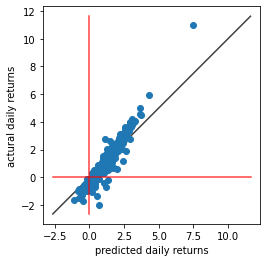

In [551]:
show_prediction_scatter(prediction, actual)

In [552]:
top10 = rf_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 5.093402300215308
        prediction     actual
8267.T    7.452569  10.971524
7936.T    4.281648   5.953878
3769.T    3.705237   4.523580
2127.T    3.669951   4.594767
7532.T    3.653415   4.967386
2181.T    3.261728   4.095164
4689.T    3.190973   3.977002
6954.T    3.088627   3.745851
6098.T    3.043341   4.189526
2897.T    3.043329   3.915344


## Random Forest2

### Predict

In [553]:
prediction = rf2.predict(predicting)

In [554]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

rf2_result = pd.DataFrame(data)
rf2_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in rf2_result.index]

### Result

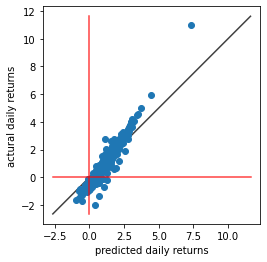

In [555]:
show_prediction_scatter(prediction, actual)

In [556]:
top10 = rf2_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 5.078728214819316
        prediction     actual
8267.T    7.336535  10.971524
7936.T    4.440756   5.953878
7532.T    3.753631   4.967386
2127.T    3.530601   4.594767
3769.T    3.465173   4.523580
2181.T    3.186944   4.095164
2897.T    3.079459   3.915344
6098.T    3.069746   4.189526
6758.T    3.066703   3.647276
3092.T    3.005637   3.928836


## XGBOOST

### Predict

In [557]:
prediction = xgb.predict(predicting)

In [558]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 2127.T
Predicted max daily return: 2.6664371490478516


In [559]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

xgb_result = pd.DataFrame(data)
xgb_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in xgb_result.index]

### Result

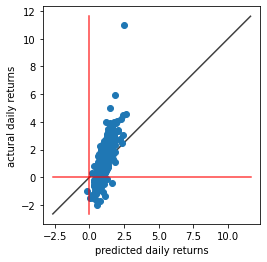

In [560]:
show_prediction_scatter(prediction, actual)

In [561]:
top10 = xgb_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 4.343025372463134
        prediction     actual
2127.T    2.666437   4.594767
8267.T    2.525169  10.971524
3769.T    2.407281   4.523580
6967.T    2.406476   3.039514
6920.T    2.347917   2.504526
6098.T    2.274603   4.189526
3064.T    2.171466   2.749446
6702.T    2.091142   3.327596
6532.T    2.055919   3.434610
2181.T    1.964093   4.095164


## XGBOOST Classification

### Predict

In [562]:
xgbclf_result = xgbclf.predict(predicting)

In [563]:
proba = xgbclf.predict_proba(predicting)

In [564]:
xgbclf_proba = pd.DataFrame(proba)

In [565]:
xgbclf_proba.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in xgbclf_proba.index]
xgbclf_proba.head()

,0,1
7203.T,0.216452,0.783548
1306.T,0.407166,0.592834
9432.T,0.350421,0.649579
6758.T,0.235589,0.764411
6861.T,0.202156,0.797844


## LightBGM

### Predict

In [566]:
prediction = lbgm.predict(predicting)

In [567]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 9468.T
Predicted max daily return: 1.7172318623202076


In [568]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

lgbm_result = pd.DataFrame(data)
lgbm_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in lgbm_result.index]

### Result

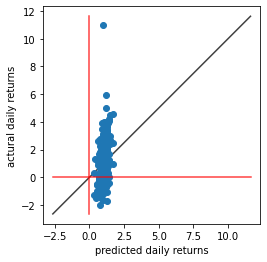

In [569]:
show_prediction_scatter(prediction, actual)

In [570]:
top10 = lgbm_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 2.560278489478905
        prediction    actual
9468.T    1.717232  0.985222
6920.T    1.716931  2.504526
2127.T    1.691346  4.594767
6762.T    1.518042  2.435897
3769.T    1.473706  4.523580
4324.T    1.468717  2.712700
6479.T    1.447391  2.980427
2413.T    1.438879 -0.422139
6869.T    1.404875  1.192640
2181.T    1.400063  4.095164


# Merge Results

In [571]:
merged_result = pd.concat(
    [
        rf_result.add_prefix('rf_'),
        rf2_result.add_prefix('rf2_'),
        xgb_result.add_prefix('xgb_'),
        lgbm_result.add_prefix('lgbm_')
    ], join='inner', axis=1)
merged_result.drop(['xgb_actual', 'lgbm_actual', 'rf2_actual'], axis=1, inplace=True)
merged_result['xgbclf'] = xgbclf_result.tolist()
merged_result.rename(columns={
    'rf_actual': 'actual',
    'rf_prediction': 'rf',
    'rf2_prediction': 'rf2',
    'xgb_prediction': 'xgb',
    'lgbm_prediction': 'lgbm'}, inplace=True)

In [572]:
merged_result.head()

,rf,actual,rf2,xgb,lgbm,xgbclf
7203.T,1.919435,2.283771,1.998648,1.214168,1.273826,1
1306.T,-0.845325,-0.995152,-0.778295,0.432227,0.976003,1
9432.T,0.339672,0.548876,0.471333,0.564770,0.904455,1
6758.T,3.018888,3.647276,3.066703,1.624202,1.225324,1
6861.T,2.670501,2.981030,2.453363,1.257706,1.294783,1


## Stacking prediction

### Stacking predict

In [573]:
final_pred = ridge.predict(merged_result.drop(['actual'], axis=1))

In [574]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 9468.T
Predicted max daily return: 1.7172318623202076


In [575]:
data = {
    'prediction': list(final_pred),
    'actual': [merged_result['actual'].iloc[i] for i in range(len(prediction))],
}

final_result = pd.DataFrame(data)
final_result.index = [i for i in merged_result.index]

### Result

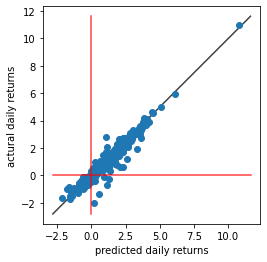

In [576]:
show_prediction_scatter(final_pred, actual)

In [577]:
top10 = final_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 5.061735035972006
        prediction     actual
8267.T   10.750336  10.971524
7936.T    6.101390   5.953878
7532.T    5.073610   4.967386
3769.T    4.505261   4.523580
2127.T    4.455358   4.594767
2897.T    4.193073   3.915344
2181.T    4.094531   4.095164
6758.T    3.985165   3.647276
4528.T    3.967335   3.971429
4689.T    3.962731   3.977002


## merge by adding all prediction

In [578]:
merged_result["prediction"] = (merged_result['rf'] + merged_result['xgb'] + merged_result['lgbm'])/3

In [579]:
top10 = merged_result.drop(columns=['rf', 'xgb', 'lgbm', 'rf2', 'xgbclf']).sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 4.9706190399744505
           actual  prediction
8267.T  10.971524    3.644255
2127.T   4.594767    2.675912
3769.T   4.523580    2.528742
7936.T   5.953878    2.436029
6098.T   4.189526    2.233486
2181.T   4.095164    2.208628
6920.T   2.504526    2.158538
7532.T   4.967386    2.096885
3092.T   3.928836    2.060984
4689.T   3.977002    2.052046


In [580]:
merged_result.sort_values(by='prediction', ascending=False).head(10)["actual"].sum()/10

4.9706190399744505

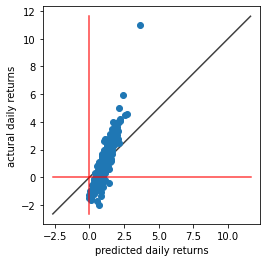

In [581]:
show_prediction_scatter(merged_result['prediction'], merged_result['actual'])

## Using classification probability

In [582]:
top10 = xgbclf_proba.sort_values(by=1, ascending=False).index

In [583]:
top10_prob = merged_result.loc[top10]['actual']
print(f"average: {top10_prob.head(10).sum()/ 10}")
top10_prob.head(10)

average: 1.5637784152463972


6723.T    1.693480
7731.T    1.147776
8355.T    0.765306
3291.T    2.870813
4004.T    1.009637
8031.T    1.063638
8697.T    0.968758
3269.T    1.538462
2002.T    1.918317
6504.T    2.661597
Name: actual, dtype: float64

# Compare

In [584]:
buying_num = 10

xgb_ave = xgb_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
lgbm_ave = lgbm_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
rf_ave = rf_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num

stack_ave = final_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
summing_ave = merged_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
percentage_ave = top10_prob.head(buying_num).sum()/buying_num

data = {
    "daily return": [xgb_ave, lgbm_ave, rf_ave, stack_ave, summing_ave, percentage_ave]
}

pd.DataFrame(data, index=['xgb', 'lgbm', 'rf', 'stack', 'summing', 'percentage_ave'])

,daily return
xgb,4.343025
lgbm,2.560278
rf,5.093402
stack,5.061735
summing,4.970619
percentage_ave,1.563778
